In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy
import scipy.stats
from scipy.stats import norm
import math
import random
import matplotlib.pyplot as plt
import pickle
from EM import EM
from plot import plot
from scipy import linalg
from numpy import ma

### Data Generation

In [2]:
class Model:
    # num_tseries is the number of time series generated by Model, each is time_length long
    # missing is the probability of an observation missing, default to zero 
    def __init__(self, time_length, num_tseries, missing=0):
        self.T = time_length
        self.num_tseries = num_tseries
        # model parameters
        self.A = np.array([[-.9, -.8]]) # the coefficients a_j's stored in a matrix
        self.b = np.array([5, 2])
        self.num_treatments = self.A.shape[1]
        self.num_chronic = self.b.shape[0]
        # noise are the variance, not standard deviation
        # noise for transition should be larger than noise for observation
        self.noise_0 = 10
        self.noise_1 = 1
        self.noise_2 = .01
        self.init_z = 6
        self.missing = missing
        # simulated data
        self.z = np.zeros((self.num_tseries, self.T))
        self.y = np.zeros((self.num_tseries, self.T))
        self.X = np.zeros((self.num_tseries, self.T, self.num_treatments))
        self.c = np.zeros((self.num_tseries, self.num_chronic))
        self.pi = np.zeros((self.num_tseries, self.T))
        
    def set_X(self, n):
        for t in range(self.T):
            self.X[n, t, :] = np.random.binomial(n=1, p=0.0, size=self.A.shape[1])# np.random.randint(2, size = self.num_treatments)

    def set_c(self, n):
        self.c[n, :] = np.random.binomial(n=1, p=0.0, size=self.num_chronic)#np.random.randint(2, size = self.num_chronic)
        
    def transition(self, prev):
        z = np.random.normal(prev, np.sqrt(self.noise_1), 1)
        return z

    def emission(self, z, n, t):
        treatment_effect = 0
        for j in range(np.shape(self.A)[0]):
            if t-1 >= j:
                treatment_effect += np.dot(self.A[j, :], self.X[n, t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c[n, :]) # total added effect
        prob = np.random.uniform(0, 1, 1)
        # to simulate time series we are dealing with, the first and last observations are not missing
        if prob < self.missing and t > 0 and t != self.T-1:
            y = np.nan
        else:
            mean = z + pi
            y = np.random.normal(mean, np.sqrt(self.noise_2), 1)
        return y, pi
    
    def pct_missing(self, n):
        pct = np.shape(np.where(np.isnan(self.y[n, :]))[0])[0]/self.T*100
        print('missing {}% of observations'.format(pct))
    
    # generate a single trajectory indexed n
    def gen_trajectory(self, n):
        self.set_X(n)
        self.set_c(n)
        self.z[n, 0] = np.random.normal(self.init_z, np.sqrt(self.noise_0), 1)
        self.y[n, 0], self.pi[n, 0] = self.emission(self.z[n, 0], n, 0)
        for t in range(1, self.T):
            self.z[n, t] = self.transition(self.z[n, t-1])
            self.y[n, t], self.pi[n, t] = self.emission(self.z[n, t], n, t)
    
    # plot the trajectory indexed n
    def plot_trajectory(self, n):
        times = list(range(self.T))
        fig = plt.figure()
        plt.plot(times, self.y[n, :], label = 'observed')
        plt.plot(times, self.z[n, :], label = 'counterfactual')
        for t in np.nonzero(self.X[n, :, :])[0]:
            plt.axvline(x=t, color='g', linestyle='--')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Simulated trajectory')
        plt.legend()
        fig.set_figheight(8)
        fig.set_figwidth(15)
        plt.show()
    
    # generate and plot multiple trajectories 
    def run_simulation(self):
        #np.random.seed(0)
        for n in range(self.num_tseries):
            self.gen_trajectory(n)
            #self.plot_trajectory(n)
            #self.pct_missing(n)

In [66]:
%%capture
# to debug loglik
for i in range(100):
    model = Model(20, 1, 0.3)
    model.run_simulation()
    em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = 1, single_effect=False)
    num_iter = em.run_EM(5000)
    #loglik_increase = all([em.expected_log_lik[j] <= em.expected_log_lik[j+1] for j in range(len(em.expected_log_lik)-1)])
    loglik_increase = all([em.obs_log_lik[j] <= em.obs_log_lik[j+1] for j in range(len(em.obs_log_lik)-1)])
    if not loglik_increase:
        break

In [67]:
i

0

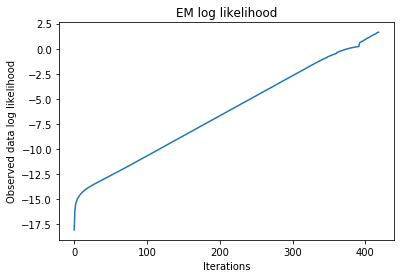

In [68]:
time = [i for i in range(len(em.obs_log_lik))]
plt.plot(time, em.obs_log_lik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

In [69]:
em.obs_log_lik[-10:]

[1.3087099124883568,
 1.3379781637146348,
 1.3785908836759202,
 1.4270157966708679,
 1.4420706974065505,
 1.4736126851198303,
 1.5275866047312139,
 1.5880999209323143,
 1.6404553979768124,
 1.640455397976811]

In [70]:
#measurements = ma.asarray(model.y)
#measurements[:, np.where(np.isnan(model.y[0, :]))[0]] = ma.masked
measurements = ma.asarray(model.y)
measurements[:, np.where(np.isnan(model.y[0, :]))[0]] = ma.masked

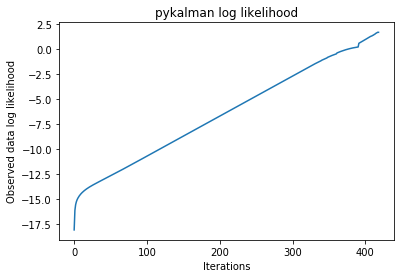

In [71]:
from pykalman import KalmanFilter
X = np.transpose(measurements)
kf = KalmanFilter(transition_matrices = 1, observation_matrices = 1, initial_state_covariance=em.init_0, initial_state_mean=em.init_state, transition_covariance=em.init_1, observation_covariance=em.init_2)
kf = kf.em(X, n_iter=num_iter, em_vars=['initial_state_mean', 'initial_state_covariance', 'transition_covariance', 'observation_covariance'])

time = [i for i in range(len(kf.loglik))]
plt.plot(time, kf.loglik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('pykalman log likelihood')
plt.show()

In [72]:
all([kf.loglik[j] <= kf.loglik[j+1] for j in range(len(kf.loglik)-1)])

False

In [73]:
kf.loglik[-10:]

[1.3321286640240313,
 1.3791853098092637,
 1.4097032551024444,
 1.465110438272577,
 1.5015638236766136,
 1.568930120661685,
 1.6141871244320887,
 1.6524571629932439,
 1.6939009928961146,
 1.6877659466002115]

In [74]:
kf.initial_state_covariance[0][0]

0.0

In [75]:
em.sigma_0

0.0

In [76]:
kf.initial_state_mean[0]

6.274620874251377

In [77]:
em.init_z

6.274620874251377

In [78]:
kf.transition_covariance[0][0]

0.5853108192431385

In [79]:
em.sigma_1

0.5853108192431395

In [80]:
kf.observation_covariance[0][0]

7.586524001605421e-16

In [81]:
em.sigma_2

8.339427867103197e-16

In [17]:
hah

NameError: name 'hah' is not defined

In [ ]:
%%capture
model = Model(20, 5, 0.3)
model.run_simulation()

In [ ]:
%%time
em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = .8, single_effect=False)
num_iter = em.run_EM(5000)

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Noise Estimates')
ax2.plot(time, em.params[len(em.params.keys())-1], label='sigma 2')
ax2.axhline(y=model.noise_2, color='g', linestyle=':', label='true value')
plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Noise Estimates')
ax2.plot(time, em.params[em.A.shape[1]+em.b.shape[0]+2], label='sigma 1')
ax2.axhline(y=model.noise_1, color='g', linestyle=':', label='true value')

plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Noise Estimates')
ax2.plot(time, em.params[em.A.shape[1]+em.b.shape[0]+1], label='sigma 0')
ax2.axhline(y=model.noise_2, color='g', linestyle=':', label='true value')

plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Coefficient Estimates')
color = ['m', 'y']
for i in range(em.A.shape[1]):
    ax2.plot(time, em.params[i], label='Coefficient A {}'.format(i+1))
    ax2.axhline(y=model.A[0, i], linestyle=':', label='true value coeffient A {}'.format(i+1), color=color[i])
for i in range(em.A.shape[1], em.A.shape[1]+em.b.shape[0]):
    ax2.plot(time, em.params[i], label='Coeffient b {}'.format(i+1-em.A.shape[1]))
    ax2.axhline(y=model.b[i-em.A.shape[1]], linestyle=':', label='true value coeffient b')
#for i in range(em.A.shape[1]+em.b.shape[0], len(em.params.keys())):
#    plt.plot(time,)
plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Initial state mean Estimates')
ax2.plot(time, em.params[em.A.shape[1]+em.b.shape[0]], label='initial state mean')
ax2.axhline(y=model.init_z, color='g', linestyle=':', label='true value')

plt.legend()
plt.show()

In [ ]:
time = [i for i in range(len(em.obs_log_lik))]
plt.plot(time, em.obs_log_lik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

In [ ]:
def mapd(actual, pred):
    return np.average(np.abs((actual-pred)/actual)) * 100

print('estimated A: {}'.format(em.A))
print('true A: {}'.format(model.A))
print('mean absolute percentage difference of A: {}'.format(mapd(model.A, em.A)))
print('estimated b: {}'.format(em.b))
print('true b: {}'.format(model.b))
print('mean absolute percentage difference of b: {}'.format(mapd(model.b, em.b)))
print('estimated initial state mean: {}'.format(em.init_z))
print('true initial state mean: {}'.format(model.init_z))
print('mean absolute percentage difference of initial state mean: {}'.format(mapd(model.init_z, em.init_z)))
print('estimated sigma_0: {}'.format(em.sigma_0))
print('true sigma_0: {}'.format(model.noise_0))
print('mean absolute percentage difference of initial state variance: {}'.format(mapd(model.noise_0, em.sigma_0)))
print('estimated sigma_1: {}'.format(em.sigma_1))
print('true sigma_1: {}'.format(model.noise_1))
print('mean absolute percentage difference of transition variance: {}'.format(mapd(model.noise_1, em.sigma_1)))
print('estimated sigma_2: {}'.format(em.sigma_2))
print('true sigma_2: {}'.format(model.noise_2))
print('mean absolute percentage difference of observation variance: {}'.format(mapd(model.noise_2, em.sigma_2)))
print('estimated ratio: {}'.format(em.sigma_1/em.sigma_2))
print('true ratio: {}'.format(model.noise_1/model.noise_2))

In [ ]:
#for n in range(model.y.shape[0]):
#    plot(em, n, time_unit=1, true_model=True, model=model, signal_name='simulation', treatment_types=['1', '2'])

In [ ]:
time = [i for i in range(len(em.expected_log_lik))]
plt.plot(time, em.expected_log_lik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Expected data log likelihood')
plt.title('EM expected log likelihood')
plt.show()

### Last Observation Carry Forward

In [ ]:
# assume the first observation is not nan and the data array is not entirely nan
def LBCF(data):
    filled = np.zeros(data.shape)
    for n in range(data.shape[0]):
        for i, y in enumerate(data[n, :]):
            if np.isnan(y):
                filled[n, i] = filled[n, i-1]
            else:
                filled[n, i] = y
    return filled

### Notes on the current model

1. Identifying coefficients is still somewhat challenging (often off by a little), especially when the noises are larger.
2. When the coefficients are too small i.e. closer to the noise value, the model is unable to recover them.
3. The model has trouble identifying the noise values.  

sigma_filter appears to converge to a value for all t > $t_0$. This replicates the updates equations, where y represents sigma_pred, x represents kgain, z represents sigma_filter. Following iterations, z always converges to one of the roots of the polynomial z^2 + a*z -a*b.